In [8]:
# %cd ..
%cd /home/janneke/Documents/Master/Machine_Learning_in_Practice/HMS/MLiP_group_10_task1_HMS/

/home/janneke/Documents/Master/Machine_Learning_in_Practice/HMS/MLiP_group_10_task1_HMS


In [9]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from logging import getLogger, basicConfig, INFO
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from generics.configs import DataConfig, Paths
from utils.eeg_processing_utils import generate_spectrogram_from_eeg

In [10]:
basicConfig(level=INFO)
logger = getLogger('main')
config = DataConfig()

TRIAL_RUN = True

In [11]:
main_df = pd.read_csv(Paths.TRAIN_CSV)
main_df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [12]:
if TRIAL_RUN:
	main_df = main_df.sample(frac = 1)  #TODO remove (added to collect some random samples instead of the first few)
	main_df = main_df.head(1000)
print(f"Number of rows in main_df: {len(main_df)}")

Number of rows in main_df: 1000


In [13]:
eeg_ids = np.asarray(main_df["eeg_id"])
eeg_paths = glob(f"{Paths.TRAIN_EEGS}*.parquet")

eegs = {}
for parquet_path in tqdm(eeg_paths):
	eeg_id = int(parquet_path.split("/")[-1].split(".")[0])
	if eeg_id in eeg_ids:
		eegs[eeg_id] = pd.read_parquet(parquet_path)

print(f"Number of EEGs found: {len(eegs)}")

  0%|          | 0/17300 [00:00<?, ?it/s]

100%|██████████| 17300/17300 [00:06<00:00, 2504.63it/s]

Number of EEGs found: 848


Show spectogram EEG of the first EEG

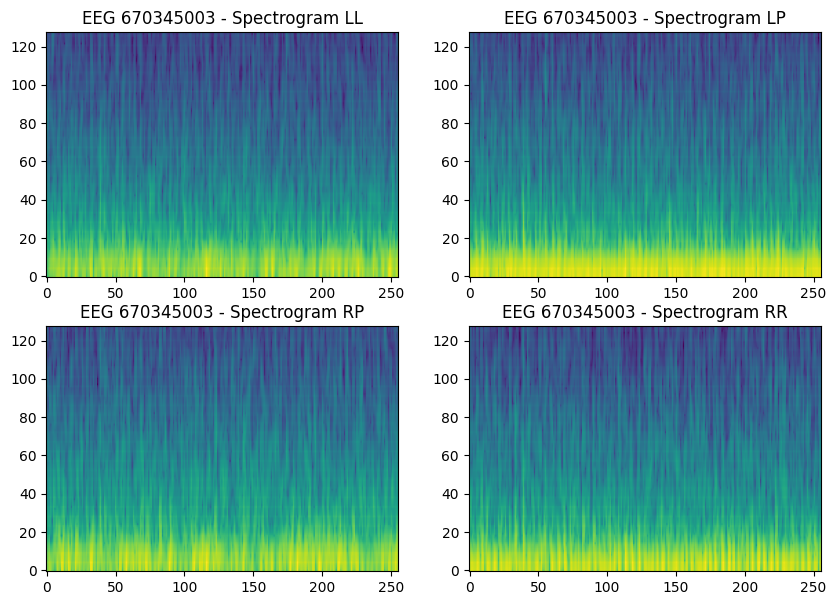

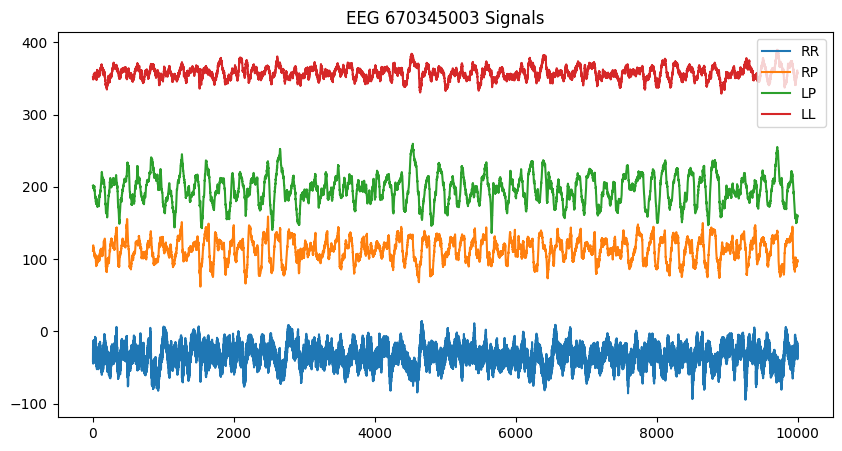

array([[[ 0.4204187 ,  0.6799309 ,  0.56472886,  0.71985924],
        [ 0.5513231 ,  0.8189884 ,  0.71606   ,  0.8566897 ],
        [ 0.61272347,  0.81632745,  0.7692557 ,  0.8573147 ],
        ...,
        [ 0.7542834 ,  0.825831  ,  0.88088644,  0.52516687],
        [ 0.83269054,  0.84664655,  0.82422566,  0.76025534],
        [ 0.7313327 ,  0.87916607,  0.66483223,  0.8827156 ]],

       [[ 0.42048138,  0.6785246 ,  0.5633136 ,  0.71845007],
        [ 0.5709566 ,  0.8156857 ,  0.71651435,  0.8532612 ],
        [ 0.63680804,  0.8117916 ,  0.7669729 ,  0.8531771 ],
        ...,
        [ 0.7566601 ,  0.8224437 ,  0.8791086 ,  0.54486775],
        [ 0.8305672 ,  0.8421706 ,  0.82652766,  0.75825703],
        [ 0.7376168 ,  0.87646925,  0.6741125 ,  0.88023174]],

       [[ 0.4205376 ,  0.67668694,  0.5614624 ,  0.7166096 ],
        [ 0.5824076 ,  0.811362  ,  0.7165235 ,  0.84877276],
        [ 0.6491618 ,  0.805833  ,  0.76391864,  0.8477501 ],
        ...,
        [ 0.75864315,  0.81

In [14]:
some_eeg_id = list(eegs.keys())[0]
some_eeg_file = f"{Paths.TRAIN_EEGS}{some_eeg_id}.parquet"
generate_spectrogram_from_eeg(some_eeg_file, display=True, display_eeg_id=some_eeg_id)

Extract simple features (mean, std, etc) and combine with one-hot encoding for the 4 groups.

In [15]:
feats = ["EKG"]
for i in DataConfig.FEATS:
	feats.extend(i)
feats = list(set(feats))

one_hot = {feat: [] for feat in feats}
one_hot["EKG"] = []
for group in DataConfig.FEATS:
	for feat in feats:
		one_hot[feat].append(int(feat in group))
one_hot_df = pd.DataFrame(one_hot, index=DataConfig.NAMES)

def extract_features(eeg_subsample: pd.DataFrame) -> np.ndarray:
	"""Extract features from eeg subsample (mean, std, etc) 
		and combine with one-hot encoding per channel

	Args:
		eeg_subsample (pd.DataFrame): subsample from an eeg (dataframe with 2000 rows)

	Returns:
		np.ndarray: 1D numpy array with features 
	"""
	desc = eeg_subsample.describe()[feats].iloc[1:]
	feature_df = pd.concat([desc, one_hot_df])
	feature_array = np.asarray(feature_df).flatten("F")

	return feature_array

Add columns with subsammle-eeg start and end index referring to the indexes of the full EEG

In [16]:
main_df.insert(len(main_df.columns), "eeg_subsample_start_index", main_df["eeg_label_offset_seconds"] * 200)
main_df.insert(len(main_df.columns), "eeg_subsample_end_index", main_df["eeg_label_offset_seconds"] * 200 + (10 * 200))
main_df = main_df.astype({"eeg_subsample_start_index": int, "eeg_subsample_end_index": int})

Find subsample EEGs within the full EEGs

In [17]:
eeg_subsamples = np.zeros((len(main_df), 2000, 20))
expert_lbls = np.zeros((len(main_df), 6))
consensus_lbls = np.zeros(len(main_df))

sample_eeg = list(eegs.values())[0].iloc[:5]
features_per_sample = np.zeros(((len(main_df), len(extract_features(sample_eeg)))))

consensus_lbl_dict = {
	"Seizure": 0,
	"LPD": 1,
	"GPD": 2,
	"LRDA": 3,
	"GRDA": 4,
	"Other": 5,
}

subsamples_added = 0
for i, (eeg_id, eeg) in tqdm(enumerate(eegs.items())):
	if eeg_id in list(main_df["eeg_id"]):
		subsamples = main_df[main_df["eeg_id"] == eeg_id]
		for j, (df_i, subsample) in enumerate(subsamples.iterrows()):
			subsample_eeg_id = subsample["eeg_sub_id"]
			subsample_consensus_lbl = consensus_lbl_dict[subsample["expert_consensus"]]
			subsample_expert_lbls = subsample[["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]]
			subsample_eeg = eeg.iloc[
				int(subsample["eeg_label_offset_seconds"] * 200) :
				int(subsample["eeg_label_offset_seconds"] * 200 + (10 * 200))
			]
			eeg_subsamples[subsamples_added + j -1] = np.asarray(subsample_eeg)
			expert_lbls[subsamples_added + j -1] = np.asarray(subsample_expert_lbls)
			consensus_lbls[subsamples_added + j -1] = subsample_consensus_lbl
			features_per_sample[subsamples_added + j -1] = extract_features(subsample_eeg)

		subsamples_added += len(subsamples)

print(f"eeg_subsamples shape: {eeg_subsamples.shape}")
print(f"expert_lbls shape: {expert_lbls.shape}")
print(f"consensus_lbls shape: {consensus_lbls.shape}")

  0%|          | 0/848 [00:00<?, ?it/s]

100%|██████████| 848/848 [00:16<00:00, 52.85it/s]

eeg_subsamples shape: (1000, 2000, 20)
expert_lbls shape: (1000, 6)
consensus_lbls shape: (1000,)


In [18]:
x = features_per_sample
y = consensus_lbls

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

Possibly let each separate model regress on one label?

In [19]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [20]:
y_pred = model.predict(x_test)
r2_score = r2_score(y_test, y_pred)

print(f"r2_score: {r2_score}")

r2_score: 0.47062089423134035


In [127]:
# dataset = CustomDataset(config=config, subset_sample_count=100, mode="train")
# dataset.print_summary()
# len(dataset.eeg_spectrograms)